--- 
Project for the course in Microeconometrics | Summer 2021, M.Sc. Economics, Bonn University | [Anum Mushtaq](https://github.com/Anum96)

# Replication of Muralidharan, K., \& Prakash, N. (2017)   <a class="tocSkip">   
---


This notebook contains my replication of the results from the following paper:

> Muralidharan, K., \& Prakash, N. (2017). Cycling to school: Increasing secondary school enrollment for girls in India. American Economic Journal: Applied Economics, 9(3), 321-50.


##### Downloading and viewing this notebook:

* The best way to view this notebook is by downloading it and the repository it is located in from [GitHub](https://github.com/OpenSourceEconomics/ose-data-science-course-project-Anum96). Other viewing options like _NBViewer_ may have issues with displaying images or disrupting the notebook (missing images can be viewed in the folder [files](https://github.com/OpenSourceEconomics/ose-data-science-course-project-Anum96/tree/master/files) on GitHub). The notebook can be viewed as an HTML file, [here.](http://open-econ.org/ose-data-science-course-project-Anum96/)


* The original paper, as well as the data and code provided by the authors can be accessed [here](https://www.aeaweb.org/articles?id=10.1257/app.20160004).


##### Information about replication and individual contributions:

* For replication, I have attempted to remain as close to the original structure of the paper as possible, concerning both the tables and figures. All tables and figures have been labeled as they appear in Muralidharan, K., \& Prakash, N. (2017). Individual contributions include an additional robustness check, plots, and the use of causal forests to calculate heterogeneous treatment effects. 



In [2]:
# import packages 

%matplotlib inline
import pandas.io.formats.style
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
import matplotlib as plt
from matplotlib import style
import seaborn as sns
from stargazer.stargazer import Stargazer, LineLocation
from dowhy import CausalModel
import zipfile
import os 


In [3]:
from auxiliary.auxiliary_data_management import *
from auxiliary.auxiliary_tables import *
from auxiliary.auxiliary_plots import *

In [5]:
for files in  zipfile.ZipFile("./data/original_data.zip").namelist():
                              zipfile.ZipFile("./data/original_data.zip").extract(files,"./out/data")
                              zipfile.ZipFile("./data/original_data.zip").close() 


# 1. Introduction 

Muralidharan, K., \& Prakash, N. (2017) study the impact of an innovative program in the Indian state of Bihar. The objective behind this program was to initialize an increase in secondary school enrollment for girls, with a motivation to reduce the probability of further increment in gender gaps within this state. Gender gap reduction has been highlighted as one of the most important goals for international educational policy over the last decade. The introduction of the Cycle Program was constructed to supply girls with bicycles that would improve their access to school which would at the same time also increase secondary school enrollment. 

As demonstrated in Figure 1, Panel A, we observe a noticeable gap in secondary schooling for individuals in their adolescent years. For these reasons, it has become essential to identify cost-effective and scalable strategies that would increase secondary school enrollment and completion rates for girls in developing countries. Policies implemented to improve educational attainment for females in developing countries have been focused on increasing the immediate benefits of schooling to families as well as motivating school enrollment by reducing costs for attending school. Demand-side policy interventions have been the most common intervention method to increase female schooling by providing conditional cash transfers (CCTS) to households to pursue girls’ enrollment in school. Demand-side interventions are quite effective as they typically aim to provide income support to the poor. On the other hand, supply-side policies have been known to assist in improving school access usually by constructing more schools or initializing programs that reduce the distance cost of attending school. As improving school access has proven to be effective at increasing school participation, it is difficult to say whether improving access to schooling should always take place in the form of further school construction. In this paper, the authors, therefore, attempt to evaluate the impact of a "Cycle Program" in Bihar (launched in 2006) that aimed to improve secondary school enrollment for girls without additional school construction. The program consisted of providing all girls enrolled in grade 9 with funds to buy a bicycle to improve convenience in accessing school. The "Cycle Program" was therefore a "conditional kind transfer" (CKT) and held features of both demand and supply-side interventions. 

The **main challenge of identification** of the program’s impact is that it was launched at a time of rapid growth and sharp increases in public spending on education across the state of Bihar. Hence, to estimate the causal impact of the Cycle Program, Muralidharan, K., \& Prakash, N. (2017) employ a **triple difference in difference** approach using data obtained from a large household representative survey conducted in 2007-2008 (eighteen months after the launch of the program). The authors employ a triple DID design using a treatment group consisting of younger cohorts (aged 14 and 15) who were exposed to the Cycle program when they were making the transition to secondary school and a control group consisting of older cohorts (aged 16 and 17) who were not exposed to the Cycle program during this transition. The authors compare changes in girls' secondary enrollment across these cohorts to account for omitted variables to changes in boys' enrollment for the same cohort. However, as we reject the assumption of parallel pre-trends in boys' and girls' enrollment we then compare this double difference estimate in the state of Bihar with the same estimate for the neighboring state Jharkhand. With the implementation of this model, we observe that having been a cohort exposed to the program resulted in an increase in girl's enrollment in secondary school. Additionally, we also observe an increase in the number of girls who appear and pass high-stakes secondary school certificate exams.


Due to our inability to completely rule out the possibility of the estimate being confounded by other factors that changed at the same time, we note that the causal impact of the Cycle Program should vary by the distance to a secondary school. We compare this triple difference estimate across villages above and below the median distance to a secondary school (3 km) and find that the impact of the program was much more strong in villages that are located 3 km or farther away from the secondary school, as shown in Figure 1, Panel B.

---

In this notebook, I aim to replicate the results presented in the paper "Cycling to school: Increasing secondary school enrollment for girls in India" by Muralidharan, K., \& Prakash, N. (2017). This notebook has been structured in the following manner. Section 2, provides a brief discussion on the identification strategy and a causal graph for visual representation, to understand the causal impact of the Cycle Program on secondary school enrollment for girls in Bihar. Section 3, provides a detailed overview of the empirical strategy with the two main equations employed for estimation. Section 4, constitutes the core of this notebook, with the replication of the study. Section 5 has the robustness checks, Section 6 is the conclusion, and Section 7 includes the Extensions, lastly Section 8 has the references. 





In [6]:
school_dist_per = pd.read_stata("out/data/schooldist.dta")
age_per = pd.read_stata("out/data/schoolage.dta")

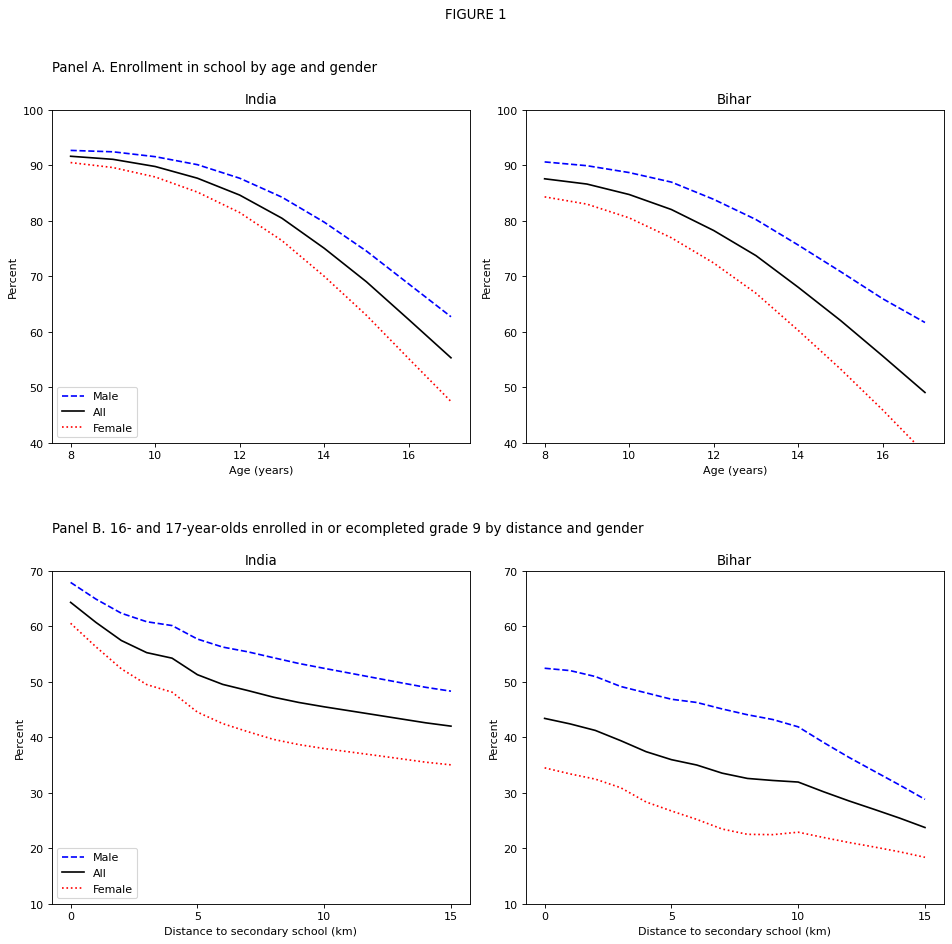

In [7]:
fig_1 = figure_1(age_per,school_dist_per)

---
# 2. Identification Strategy
---

Muralidharan, K., & Prakash, N. (2017) study student enrollment or completion of grade 9 (the first year of secondary school) as an outcome variable by constructing a triple difference estimate (DDD). The first difference is estimated across girls aged 14 or 15 in Bihar ('treated' cohort) and girls aged 16 and 17 ('untreated'/'control' cohort). The presence of several factors related to the enhancement of school enrollment in Bihar at the same time as the Cycle Program, namely increasing household incomes and increased public investment in education, results in a confounded estimate. For this reason, the authors use boys as a control group, as they would be exposed to external factors that affect school enrollment during the period of interest but were not eligible for the program. However, since girls’ enrollment was already quite low, it is impossible to measure whether the growth of their enrollment was faster than boys. Parallel trends in boys' and girls' enrollment growth were tested four years before the program  (2002–2003 to 2005–2006) using official enrollment, rejecting the null hypothesis of parallel trends as shown in (Table 1, panel A).

The DDD estimate of the program impact is estimated by comparing the double-difference with the same double difference in the neighboring state of Jharkhand, this state was not part of the Cycle Program, hence we consider Jharkhand as a comparison group for Bihar. The credibility of this comparison group for Bihar is assured by the fact that both states were unified (Jharkhand was a part of Bihar) until 2001 and were administratively bifurcated into two states in 2001. Thus the governance structure of the two states was identical until 2001, and the quality of governance in the two states was comparable for a few years after the bifurcation.


The causal graph below illustrates the relationship between the treatment variable (Cycle Program) $D$, the outcome variable (secondary school enrollment) $Y$, and the treated group $T$. There is present a confounding variable ($U$) as discussed above, that affects $Y$ and $D$. There are additionally three variables that affect the treated group $T$, namely $Sex$, $Age$ and $State$, and also $Y$. The effect of $Sex$ on the treated group is that it determines which group receives treatment as we reject parallel trends between boys and girls, $Age$ determines the age requirement as only those between the ages of 14-15 (inclusive) were provided with funds to purchase a bicycle and $State$, as only Bihar was introduced to the Cycle Program. Plus the observables $W$ also affecting $Y$. We have now identified multiple back door paths that are required to be closed to isolate the effect of the Cycle Program and truly understand the impact of this impact on secondary school enrollment. The authors attempt to control for most of the unobservables, by employing demographic, household socioeconomic, and village level controls, however, the use of control variables does not eliminate the impact of these unobservables. Therefore, to isolate the effect of a treatment the authors employ a triple difference-in-difference. 





<img src="files/causal_graph_1.png" width="800" />



 
As we observe Equation 2, the authors aim to estimate the impact of the Cycle Program on the number of girls who appear in the SSC exam and the number who pass this exam (both in logarithms of school-level figures). We are now able to observe both before the treatment went into effect and after. We find that the treatment $D$ affected the outcome $Y$. Ideally, we could just observe $Y$, however, it is possible that the $Y$ could have risen for all the groups the time the treatment was imposed and not just for the Treated group $D$.  Additionally, it is important to note that in this case there is also the effect of the confounding variable, public spending on education. Hence, before treatment is the years from 2004-2007, and then after-treatment years are from 2009-2010. The difference between the $Y$ before treatment and $Y$ after treatment for the treated group reflects the effect of Treatment $D$ on Y and the way that $Y$ would have been altered for reasons unrelated to the $D$. Time gives us a back-door path from treatment Treatment$(D)$ → $Y$ path, or  Treatment$(D)$ ← $Time$ → $Y$ path. To resolve this issue, we add a control group that does not receive treatment, this allows us to control for a time, but introduces the problem of another backdoor, as there might exist differences between the groups. We close both back-door paths through Time and Treated group $T$ using Differences-in-Differences. The idea is now that we observe the change in $Y$ from Before and After in the Treated group and the change in $Y$ from Before and After in the Control group. Additionally, we have $Sex$ and $State$ that affect both the treated group and the outcome variable.



![ERROR:Here should be causal graph 2](files/causal_graph_2.png)
 
 
**Average Treatment Effect for Difference-in-Difference**

For the difference-in-difference estimation, we define the target estimated in terms of the potential outcome. We use the average effect of treatment on the treated (ATT). This provides comparison of the potential outcome with treatment to the epotential outcome with no treatment, in the treated group. The ATT is mathemtically written as : 



\begin{equation}
ATT = E[Y^{1}(2)-Y^{0}(2)|A=1]
\end{equation}

$Y^{a}(t)$ is the potential outcome given teatment $a$ at time $t$ = 2 represents the post treatment period $a$=1 represents the treatment  and $a$ = 0 represents no treatment, however in our model shown in Table 2, we do not use a time period to represent pre and post treatment period, we instead create a treated group, hence this can be written as: 

**Expected|secondary school enrollment with Cycle Program -  secondary school enrollment with no Cycle Program]**


If we could observe the potential outcomes for both treatment and with no treatment, estimating the ATT could be convenient. We would then have to simply calculate the difference in these two potential outcomes for each treated unit, and take the average. However, it is not possible to observe the potential outcomes at the same time, the potential outcomes in the treatment group are factual, but the potential outcomes with the no treatment are counterfactual. For these reasons in the difference-in-difference, we use observations from the control group to impute untreated outcomes in the treated group. 

Using the assumptions of consistency and counterfactual assumption (parallel trends) we can create the identification. For a difference-in-difference identification we have first the ATT, which applies the initial assumption of counterfactual assumption and then the consistency assumption, giving us: 



 \begin{equation}
ATT = E[Y^{1}(2)-Y^{0}(2)|A=1]
\end{equation}
 \begin{equation}
\left \{ E \right[Y(2)|A=1] -E[Y(1)|A=1]\}-\left \{ E \right[Y(2)|A=0] -E[Y(1)|A=0]\}
\end{equation}

* The post-intervention average of the treated group  for $E[Y(2)|A=1]$
* The pre-intervention average of the treated group  $E[Y(1)|A=1]$
* The post-intervention average of the control group for $E[Y(2)|A=0]$
* The pre-intervention average of the control group for $E[Y(1)|A=0]$



In [8]:
enroll_data = pd.read_stata(
    "out/data/bh_enroll_data_reg.dta", convert_categoricals=False
)
enrollment_data = gen_table_one_reg_data(enroll_data)

In [11]:
table_1(enrollment_data)

|| 
|:---|:---:| 
|<td colspan=2>Dependent variable: log (9th grade enrollment by school, gender, and year)| 
||(1)|
|*Panel A. Testing parallel trends for difference-in-differences(DD)||||| 
|Female x year|0.0518| 
||(0.0)| 
|Female|-0.87| 
||(0.06)| 
|Year(coded as 1 to 4)|0.0852| 
||(0.01)| 
|Observations|20266| 
|*Panel B. Testing parallel trends for triple differences(DDD)||||| 
|Female x year x Bihar|-0.01| 
||(0.01)| 
|Female x year|0.0618| 
||(0.01)| 
|Female x Bihar|0.1751| 
||(0.11)| 
|Bihar x year|0.029| 
||(0.01)| 
|Female|-1.0451| 
||(0.09)| 
|Year|0.0562| 
||(0.01)| 
|Bihar|-0.1233| 
||(0.12)| 
|Constant|(4.358)| 
||(0.11)| 
|Observations|22279| 
|R^2|0.171| 
<td colspan=5>Notes: The analysis uses administrative data on enrollment at the school level by gender and grade for the four school years after the bifurcation of the unified Bihar into the states of Biharand Jharkhand, prior to the launch of the Cycle program (2002–2003 through 2005–2006). Each observation corresponds to the log of school-level ninth grade enrollment by gender andyear (with the four years of data being as Years 1 to 4). Panel A uses only data from Bihar and tests for parallel trends in boys’ and girls’ secondary-school enrollment rates in Biharfor the four-year period prior to the Cycle program. Panel B includes data from both Bihar and Jharkhand, and tests for parallel trends in the double difference across the two states inthe same four-year period. The data includes all 38 districts in Bihar and the 10 districts in Jharkhand bordering Bihar. Standard errors, clustered by district ID, are in parentheses.

With the coefficient on the triple interaction term being close to zero (Table 1, panel B) we find that we do not reject the null hypothesis of parallel trends for the triple difference in the period 2002–2003 to 2005–2006.

---
<span style="color:orange">**NOTE**:</span> We have school-level enrollment data for all schools in Bihar (where the GoB facilitated data collection),
but in Jharkhand we only have data for the 10 districts that border Bihar (out of a total of 24), since field teams
had to visit each district to collect this data. Thus analysis of parallel trends is based on using all districts in Bihar
and border districts in Jharkhand, while the main analysis (using the DLHS data) uses all the districts in Bihar and Jharkhand.

---


---
# 3. Empirical Strategy and Estimating Equations
---


The triple-difference estimate of exposure to the Cycle program is estimated by: 

(1) \begin{equation}
y_{ihv} = \beta_{0} + \beta_{1}.F_{ihv}.T_{ihv}.BH_{ihv}+
\beta_{2}.F_{ihv}.BH_{ihv}+
\beta_{3}.T_{ihv}\times BH_{ihv}+\beta_{4}.F_{ihv}.T_{ihv}+
\beta_{5}.F_{ihv}+\beta_{6}.T_{ihv}+
\beta_{7}.BH_{ihv}+\varepsilon_{ihv},
\end{equation}



* $Y_{ihv}$ outcome variable of interest corresponding to child i in household $ihv$ is an indicator for being $h$ and village $v$;  
* $F_{ihv}$ is an indicator for being female,
* $T_{ihv}$ s an indicator for being  in a “treated” cohort (being aged 14 or 15),
* $BH_{ihv} $ is an indicator for an observation from Bihar,
* $\varepsilon_{ihv} $ is the error term,
* $\beta_{1}$ is the main parameter of interest,
* $\beta_{2} - \beta_{7}$ are the estimates of the double interaction terms and linear terms


The estimation sample includes all members of the household roster in surveyed households aged 14 to 17 in Bihar and Jharkhand, and the omitted category of 16 and 17-year-olds corresponds to the “control” cohorts. Standard errors are clustered at the village level.



---
<span style="color:orange">**NOTE**:</span> The test for parallel trends uses school-level enrollment data and has to
be estimated in logs and not levels because the population base and distribution of
school size in Bihar and Jharkhand are different.

---

The **summary statistics** (shown below) in the estimation sample (Table A.1) have been gathered from the *Online Appendix* and represent the significant differences between Bihar and Jharkhand, especially in terms of the share of disadvantaged scheduled castes and tribes, with the latter having a much larger share of the tribal population. To account for these differences when estimating equation (1) we include a progressively rich set of controls for demographic, socioeconomic, and village characteristics. We present $\beta_{1}$ for each of these specifications, with a focus primarily on the discussion with the estimation with a full set of the village and household controls. 


*Quadruple Difference Estimate* - Despite the non-rejection of the parallel trends for the triple difference (Table 1, panel B), the estimate $\beta_{1}$ in equation (1) is likely to be confound by omitted variables that differentially affect the trend in girls' secondary school enrollment in Bihar relative to Jharkhand after 2006. These issues have been addressed by noting that the estimate  $\beta_{1}$ in equation (1) is causal, and we should expect to see heterogeneous effects of the program as a function of distance to the nearest school. Since the Cycle Program would have been associated with a reduction in the cost of distance to school, the triple difference should be larger in cases where a secondary school was further away. The median village in Bihar was three kilometers (km) away from a secondary school. The variable $LD_{v}$('long distance') takes the value of 1 if a village is 3km further away from a secondary school, we estimate a quadruple difference using the specification:


(2) \begin{equation}
y_{ihv} = \beta_{0} + \beta_{1}.F_{ihv}.T_{ihv}.BH_{ihv}.LD_{v}+\sum_{i=2}^{5}\beta_{i}.(4 \, \, T riple\, Interactions) + \sum_{i=6}^{11}\beta_{i}.(6\, \, Double\, Interactions) + \sum_{i = 12}^{15}.\beta_{i}.(4 \, \, Linear \, Terms) + \varepsilon_{ihv}, 
\end{equation}


* $\beta_{1}$ is the main parameter of interest, and indicates the extent to which the triple difference estimate in equation (1) is differentially coming from villages further away from a secondary school. 

The estimation sample, controls, and clustering are as in equation (1).


*Non-parametric Triple Difference Estimate (DDD by Distance to Secondary School)*  We enrich the analysis above by nonparametrically plotting the triple difference estimate in equation (1) as a function of the distance to the nearest secondary school. The benefits of school attendance are less likely to depend on the distance to school while the costs can be thought of as linear in travel time. The provision of a cycle would therefore reduce the cost of school attendance proportional to the original distance from the nearest
secondary school. We would expect the impact to be low in villages where there is a secondary school nearby (since the marginal impact of the cycle would below). 



In [8]:
summary_stat = table_sum
summary_stat

|||||| 
|:---|:---:|:---:|:---:|:---:| 
|**Summary Statistics (estimation sample)**||||| 
||Bihar|Jharkhand| 
|**Panel A. Dependent variable**||||| 
|Enrolled in or completed grade 9 (Among 14-17 year olds)|0.31|0.34| 
||(0.46)|(0.47)| 
|**PANEL B: Key independent variables**||||| 
|Treatment group = Child age 14 & 15 (Among 14-17 year olds)|0.54|0.59| 
||(0.50)|(0.49)| 
|Female|0.49|0.47| 
||(0.50)|(0.50)| 
|**PANEL C: Demographic Characteristics**||||| 
|Social group: Scheduled caste|0.19|0.14| 
||(0.39)|(0.34)| 
|Social group: Scheduled tribes|0.02|0.36| 
||(0.15)|(0.48)| 
|Social group: Other backward caste|0.59|0.42| 
||(0.49)|(0.49)| 
|Social group: Hindu|0.85|0.65| 
||(0.36)|(0.48)| 
|Social group: Muslim|0.15|0.12| 
||(0.36)|(0.32)| 
|**PANEL D: Demographic Characteristics**||||| 
|Household head years of schooling|4.32|3.94| 
||(5.03)|(4.43)| 
|Household head Male|0.86|0.95| 
||(0.35)|(0.21)| 
|Land (<5 acres = marginal farmer)|0.95|0.93| 
||(0.22)|(0.25)| 
|Below poverty line|0.29|0.4| 
||(0.45)|(0.49)| 
|Household owns TV/Radio|0.272|0.31| 
||(0.45)|(0.46)| 
|Household access to electricity|0.2|0.26| 
||(0.40)|(0.44)| 
|**PANEL E: Village Characteristics**||||| 
|Primary school in village|0.88|0.89| 
||(0.32)|(0.31)| 
|Middle school in village|0.47|0.54| 
||(0.50)|(0.50)| 
|Secondary school in village|0.11|0.07| 
||(0.32)|(0.26)| 
|Bank in village|0.1|0.06| 
||(0.30)|(0.24)| 
|Post office in village|0.32|0.21| 
||(0.47)|(0.41)| 
|Distance to bus station (km)|7.35|12.15| 
||(9.94)|(12.81)| 
|Distance to nearest town (km)|14.0|17.65| 
||(13.94)|(15.46)| 
|Distance to railway station (km)|18.21|33.96| 
||(42.12)|(30.64)| 
|Distance to district headquarter (km)|32.94|39.39| 
||(37.26)|(24.51)| 
|Log (Village current population)|7.79|6.87| 
||(1.17)|(0.83)| 
|Observations|18,453|11,842| 


---
# 4. Replication of Muralidharan, K., & Prakash, N. (2017)
---

### 4.1 Data & Descriptive Statistics

1. Muralidharan, K., & Prakash, N. (2017) use the third wave of the Indian District Level Health Survey (DLHS - 3) conducted in 2007 - 2008 as the main data source. 
* The DLHS-3 is a household survey with 720,000 households across 601 districts. 
* The data includes household socioeconomic characteristics and a roster of all members in the household, their education attainment, and current schooling status
* The village-level questionnaire in the DLHS includes information on all educational facilities available in the village, and the distance to the nearest educational facility of each type that is not available in the village (including primary, middle, and secondary schools).
* The data provides us with information of households that have at least one member aged 14 to 17 living in the states of Bihar and Jharkhand which is used for the estimation sample. 

The two other datasets used in this paper include : 

2. School-level secondary school enrollment data by gender for both Bihar and Jharkhand
* This data is used from the years before the launch of the program (2002 to 2006) to test for parallel trends in the growth rate of enrollment of boys and girls in Bihar and Jharkhand.
3. Muralidharan, K., & Prakash, N. (2017) collect official data on the number of students who appeared in and who passed the secondary school certificate (SSC) examination in both Bihar and Jharkhand. 
* This data comes from the official state exam boards and only reflects those students who took the exam and were graded for it, and is hence much more reliable than school-based enrollment records.

*Note*: Neither of these two datasets includes information on the distance to the nearest school for individual students, and so the authors can only study heterogeneity of impact by distance in the DLHS-3 household data. However, the annual school-level data to test for parallel trends as the DLHS-3 is only collected at one point in time.


In [9]:
# Load the data sets 
dlhs_long = pd.read_stata(
    "out/data/dlhs_long_wdist.dta", convert_categoricals=False
)

enroll_data = pd.read_stata(
    "out/data/bh_enroll_data_reg.dta", convert_categoricals=False
)


exam_data = pd.read_stata("out/data/exam_data.dta"
)

In [10]:
regression_data = gen_dlhs_reg_data(dlhs_long)

divide by zero encountered in log


---
<span style="color:orange">**NOTE**:</span> The original data provided by the authors can be found [here](https://www.aeaweb.org/articles?id=10.1257/app.20160004). For the purpose of replication the data set "dlhs_long_wdist.dta" has been cleaned in order to produce the data set "dlhs-reg-data.dta". This data set contains all the variables, including the interaction i.e. the DD, DDD, and DDDD, that are needed to produce the tables using DLHS III data in this study.

---

Below we have provided a descriptive statistics table that accounts for the variables used in Table 2 and Table 3. 

In [11]:
Table_1 = create_table1(regression_data)
Table_1

Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


,Minimum,Mean,Median,Standard Deviation,Maximum,Description,Type
enrollment_secschool,0.0,0.14,0.0,0.35,1.0,Indicator variable for enrolled in or complete...,Outcomes
treat1_female_bihar,0.0,0.15,0.0,0.36,1.0,Females in Bihar in age group age 14-15 years old,Covariates
treat1_female,0.0,0.26,0.0,0.44,1.0,Females aged 14-15 years old,Covariates
treat1_bihar,0.0,0.33,0.0,0.47,1.0,Aged 14-15 years old in Bihar,Covariates
female_bihar,0.0,0.31,0.0,0.46,1.0,Females in Bihar,Covariates
treat1,0.0,0.56,1.0,0.50,1.0,Main treatment - aged 14-15 years old,Covariates
female,0.0,0.50,0.0,0.50,1.0,Female,Covariates
bihar,0.0,0.61,1.0,0.49,1.0,Bihar,Covariates
treat1_female_bihar_longdist,0.0,0.08,0.0,0.26,1.0,Females in Bihar in age group age 14-15 years ...,Covariates
treat1_female_longdist,0.0,0.15,0.0,0.36,1.0,Females aged 14-15 years old located 3km or fu...,Covariates


## 4.2 Results 
### A. *Enrollment Impact*

Table 2 presents the triple difference estimate of the impact of the Cycle Program, based on equation (1). Columns 1 and 2, represent the estimates with no controls and with demographic controls and suggest that the impact of the program on ninth-grade enrollment (or completion) was about 11-12 percentage points, the estimates including controls for household education and assets reduced the estimate by 5.2 percentage points, column 3 and 4 represent the estimate with no further change from including village-level controls. 

First, the coefficient on the "treatment" dummy (an indicator for being 14 or 15 years old) is negative. The reason for this may be associated with students enrolling or completing grade 9 much later than the expected age (for reasons including grade repetition, late starting of school, or dropping out and rejoining school). Hence, the treatment effects should reflect an increase in the likelihood of girls being enrolled or completing grade 9 *at a grade-appropriate age* and not as the impact on total secondary school enrollment of girls. In this case, the dependent variable is, therefore, the net enrollment rate (NER), which is a common measurement of educational attainment. 

Second, while the difference in the estimate of $\beta_{1}$ is not significant between columns 2 and 3 in Table 2, the magnitude of $\beta_{1}$ is lower when we include socioeconomic controls, raising the concern that the triple difference strategy may not be enough to account for omitted variables. The preferred estimates in Table 2, are reflected in column 4, which contain a full set of household, demographic, and village-level controls. According to the authors, the estimated impact of the Cycle Program has proven to increase secondary school NER of girls by 5.2 percentage points. 


In [12]:
Table_2 = table_2(regression_data)
Table_2

### B. *Heterogeneity of Enrollment Impact*

Any remaining omitted variable concerns are targeted by looking at the heterogeneity of the triple difference (DDD) estimate as a function of distance to the nearest secondary school. Table 3 presents the quadruple difference (DDDD)  results based on estimating equation (2). The triple difference estimate DDD has been decomposed according to whether a respondent resides in a village above the median distance to the secondary school (3 km). We find that households located 3 km or further away from a secondary school are the main drivers for the DDD estimates. 

It was estimated that having been a cohort exposed to the Cycle Program resulted in an increase in girls’ secondary school NER by 87 percent and a reduction in NER gender gap of 54 percent. Additionally, for households located at a distance less than 3 km, there was found to be no impact. This suggests that the triple difference estimates are not confounded by omitted variables that would have differentially improved girls’ enrollment in Bihar during the period of rapid growth and increase in education spending. Furthermore, this result suggests that the main mechanism behind the impact was the reduction in the “distance cost” of attending school, which was made possible by the introduction of the bicycle. 


In [13]:
Table_3 = table_3(regression_data)
Table_3


We further explore this result by plotting the DD and DDD estimates (from Table 2) nonparametrically as a function of distance to a secondary school. Panels A and B in Figure 2 present the nonparametric plots of the DD estimates for Bihar and Jharkhand, respectively and Panel C shows the DDD plot as a function of distance to the nearest secondary school. The plots also include bootstrapped 95 percent confidence intervals. 

Panel C represents the inverted U-pattern, providing proof that increases in enrollment mostly took place in villages further away from a secondary school, suggesting that the mechanism of impact was the reduction in time and safety cost made possible by the bicycle. The bootstrapped confidence intervals suggest that the DDD estimates are positive and significant with distances between 5 to 13 kilometers, a part of the intermediate-range of distance to school at which we would expect to see a positive effect as shown in Online Appendix Figure A.2.


Panels A and B highlight the importance of the use of Jharkhand as a control group, for the reason that there are consistent positive DD estimates in Jharkhand for all distances, suggesting girls' secondary school enrollment would be increasing anyway. However, in Jharkhand, this gain seems more likely to have happened when secondary
schools were more easily accessible and are typically insignificant at most distances above 5 km. Bihar also saw a considerable gain at all distances, and so it is the
triple difference that highlights the fact that most of the gains in enrollment relative to Jharkhand occur at intermediate distances.



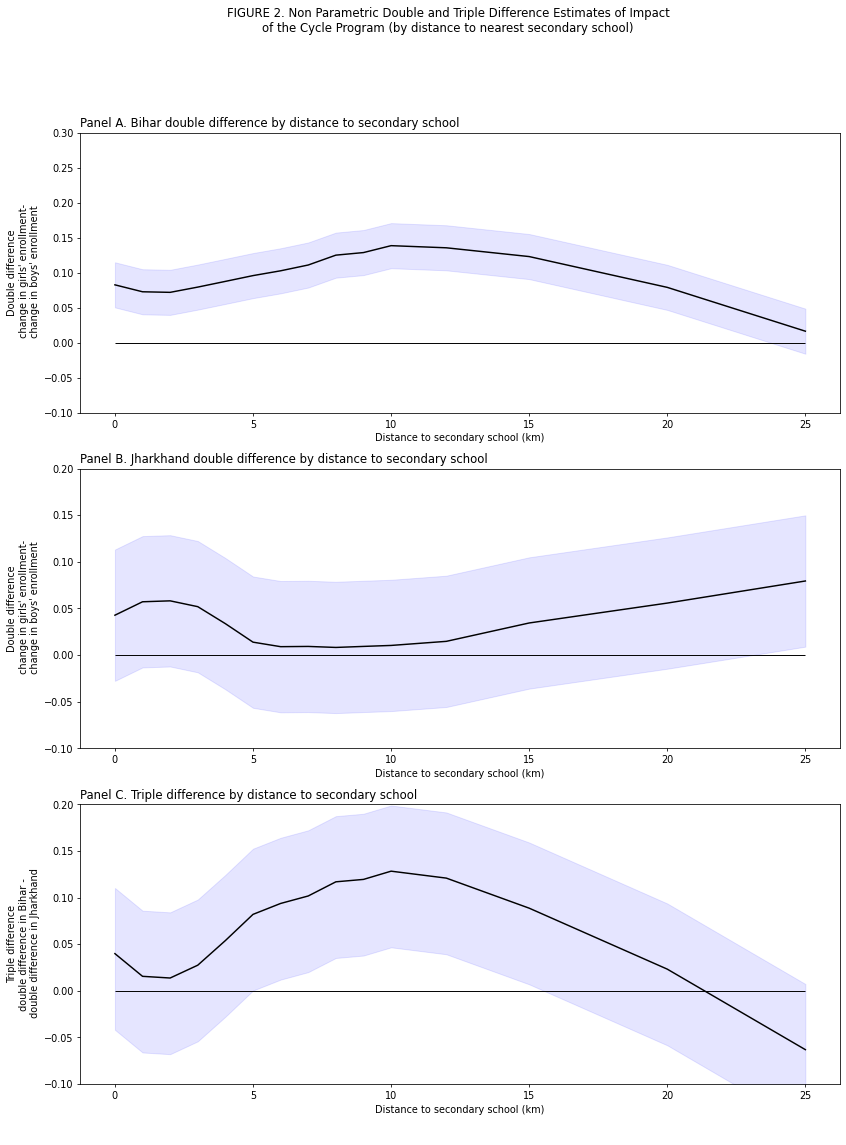

In [14]:
dist_data_per = pd.read_stata("out/data/ddd_long.dta")
fig_2 = figure_2(dist_data_per)

From Figure A.1 from the Online Appendix

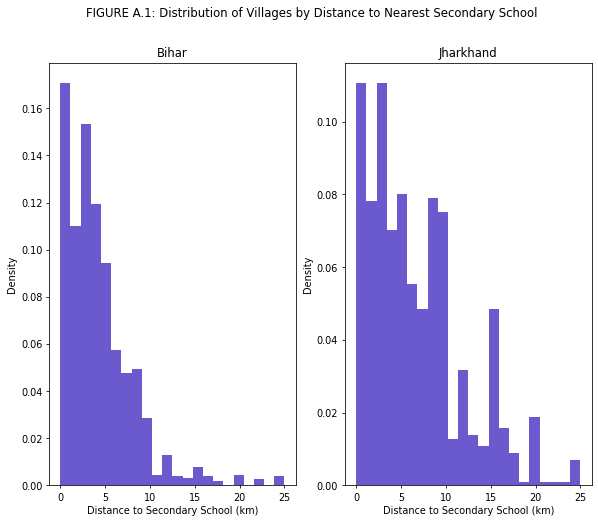

In [15]:
figure_1_oa = pd.read_stata("out/data/dlhs-figure-A.1.dta"
)
fig_3 = figure_3(figure_1_oa)

### C. *Impact on Learning Outcomes*

To study the impact of the Cycle Program on learning outcomes, Muralidharan, K., & Prakash, N. (2017) collected official administrative data on appearance and performance in the secondary school certificate (SSC) exams. Muralidharan, K., & Prakash, N. (2017)  code 2009 - 2010 as "Post" program years since there is a two-year lag between entering secondary school and taking the exam, and the Cycle Program was launched in 2006. "Pre" program years include 2004 - 2007 (omitting 2008 as the transition year). The parallel trends assumption is rejected for the double-difference and not rejected for the triple difference, the authors, therefore, focus on the triple-difference estimate. 

Table 4 presents results on *two outcomes* - the number of girls who appear in the SSC exam and the number who pass this exam (both in logarithms of school-level figures). From the results, we observe that cohorts exposed to the Cycle Program had a significant 18 percent increase in the number of girls who appeared for the SSC exam, which is 56 percent of the measured 32 percent increase in female secondary NER in the household survey reported earlier. With this result, we find that the Cycle Program did not only increase enrollment but also significantly increased the number of girls who completed two years of extra schooling as they took part in the SSC exam. The authors also find a 12 percent increase in the number of girls who pass the SSC exam. 

The combination of enrollment and exam results suggest that around 37 percent of the increased enrollment (12 percent out of 32 percent) also translated into increases in secondary school completion. Moreover, the increase in SSC exam pass rates is a credible measure of increased human capital accumulation as the SSC exam is the first externally evaluated credential of learning outcomes in the Indian schooling system. 





### Extension: Plotting the distribution of Females who appeared and passed the SSC Exam from 2004 - 2010

From Figure 4, we can observe an increase in total appearance and pass in SSC Exams for Females from the years 2004-2010. From this data we create our analysis and estimate the increase in both outcome variables for females in Bihar post the introduction of the Cycle Program. 

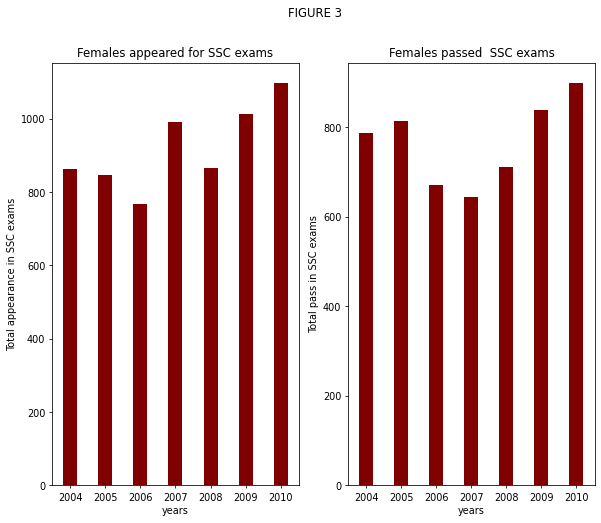

In [29]:
fig_3 = fig_4(exam_data)

In [17]:
exam_data = pd.read_stata("out/data/exam_data.dta"
)
table_4(exam_data)

divide by zero encountered in log


## 5. Robustness Checks

### A. *Alternative Definition of “Treated” and “Control” Cohorts*

One of the limitations of the study is its inability to conduct the analysis using panel data but instead using a single cross-sectional household survey conducted 18 months after the launch of the Cycle Program. If panel data was present, the authors would have the opportunity to observe the schooling history of students by age and grade. As result, the impact of the Cycle Program can only be estimated on *age-appropriate* girls' enrollment or completion in ninth grade as opposed to the impact on *total* enrollment. Additionally, older children in the household (especially those who are 17) may be underrepresented in the data if they had chosen to migrate out for marriage or employment. The authors, therefore, continue to examine the robustness of their estimations to alternative definitions of the treatment and control cohorts. 

Table 5, Panel A represents the age distributions of students currently enrolled in grade 9. With the mean, median and modal ages of being enrolled in grade nine are between 14 and 15, the focus is majorly on these ages as the "treated" cohort, however with considerable enrollment in grade 9 at ages 13 and 16, this has the potential of resulting in an underestimation of the overall program impact as some girls aged 16 and 17 in Bihar (considered the control cohort) may be enrolled in school because of the Cycle Program. Documentation of the age distribution of respondents in the sample corresponding to Table 5, Panel B show that there is a noticeable reduction in the sample size for the 17-year-old cohort, suggesting that this cohort may be more likely to have left the household, with boys migrating out in search of employment and girls getting married and leaving home. Girls migrating out for marriage were also less likely to have completed secondary school, the gender gap in the 17-year old cohort may be understated, which may bias the treatment effect downwards, and suggests a case for excluding the 17-year-old cohort from the estimation sample. 

Hence, three sets of alternate definitions of treatment and control cohorts were considered. First, the inclusion of 13-year-olds in the treated cohort (since 17 percent of girls in grade 9 are 13 years old in Table 5, Panel A) and compare cohorts aged 13-15 (treatment) to those aged 16-17 (control). Second, we drop the 17-year-old cohort from the estimation and compare cohorts aged 14-15 (treatment) to the one aged 16 (control). Finally, there is a comparison between cohorts aged 13-15 (treatment) to the one aged 16 (control), the results have been presented from all three sets of comparison in Table 6. 

---
<span style="color:orange">**NOTE**:</span> We do not include age 18 and above because the DLHS only asks for grade of current enrollment for respondents under 18 (respondents who were 18 years or older were only asked to report their highest completed grade).

---


In [18]:
table_5_panel_a(regression_data)

freq       per
female state age                 
0      10    12.0   107  0.081061
             13.0   172  0.130303
             14.0   334  0.253030
             15.0   322  0.243939
             16.0   269  0.203788
             17.0   116  0.087879
       20    12.0   101  0.098729
             13.0   141  0.137830
             14.0   234  0.228739
             15.0   283  0.276637
             16.0   164  0.160313
             17.0   100  0.097752
       total 12.0   208  0.088775
             13.0   313  0.133589
             14.0   568  0.242424
             15.0   605  0.258216
             16.0   433  0.184806
             17.0   216  0.092190
1      10    12.0    73  0.083049
             13.0   152  0.172924
             14.0   153  0.174061
             15.0   251  0.285552
             16.0   168  0.191126
             17.0    82  0.093288
       20    12.0    89  0.114987
             13.0   126  0.162791
             14.0   245  0.316537
             15.0   135  0.174419
             16.0   123  0.158915
             17.0    56  0.072351
       total 12.0   162  0.098004
             13.0   278  0.168179
             14.0   398  0.240774
             15.0   386  0.233515
             16.0   291  0.176044
             17.0   138  0.083485

In [19]:
table_5_panel_b(regression_data)

freq       per
female state age                 
0      10    13.0  2247  0.191283
             14.0  2627  0.223632
             15.0  2915  0.248148
             16.0  2421  0.206095
             17.0  1537  0.130842
       20    13.0  1383  0.181496
             14.0  1612  0.211549
             15.0  2018  0.264829
             16.0  1531  0.200919
             17.0  1076  0.141207
       total 13.0  3630  0.187432
             14.0  4239  0.218877
             15.0  4933  0.254712
             16.0  3952  0.204058
             17.0  2613  0.134920
1      10    13.0  2990  0.250356
             14.0  1829  0.153144
             15.0  2654  0.222222
             16.0  2687  0.224985
             17.0  1783  0.149292
       20    13.0  1608  0.222931
             14.0  2074  0.287536
             15.0  1239  0.171773
             16.0  1344  0.186330
             17.0   948  0.131429
       total 13.0  4598  0.240029
             14.0  3903  0.203748
             15.0  3893  0.203226
             16.0  4031  0.210430
             17.0  2731  0.142566

---
The first and second rows in each panel of Table 6 represent the triple interaction and quadruple interaction terms of interest from estimating equations (1) and (2) and are corresponding to the first row of Table 2 and 3 respectively. We can find that the main results continue to hold in all three panels. Interestingly we observe a larger impact when the 17-year-old is excluded from the estimation sample, with the quadruple difference significant now at a 5 percent level and not just the 10 percent level (Panel B and C). 

Alternatively, the impact of the Cycle Program can be viewed by observing the enrollment gender gaps by age and check the extent to which the gender gap is lower in Bihar for younger cohorts exposed to the program. 


In [20]:
table_6(regression_data)

|||||| 
|:---|:---:|:---:|:---:|:---:| 
|<td colspan=5>Dependent variable: Enrolled in or completed grade 9| 
||(1)|(2)|(3)|(4)| 
|*Panel A. Treatment = 13, 14, 15; control = 16, 17*||||| 
|Treat × female × Bihar|0.084|0.075|0.049|0.048| 
||(0.027)|(0.026)|(0.023)|(0.023)| 
|Treat × female × Bihar × long distance indicator|0.086|0.083|0.081|0.08| 
||(0.052)|(0.05)|(0.045)|(0.045)| 
|Observations|38523|38523|38329|38286| 
|*Panel B. Treatment = 14, 15; control = 16*||||| 
|Treat × female × Bihar|0.127|0.114|0.077|0.076| 
||(0.034)|(0.033)|(0.029)|(0.029)| 
|Treat × female × Bihar × long distance indicator|0.116|0.11|0.119|0.119| 
||(0.066)|(0.064)|(0.058)|(0.058)| 
|Observations|24951|24951|24830|24798| 
|*Panel C. Treatment = 13, 14, 15; control = 16*||||| 
|Treat × female × Bihar|0.108|0.098|0.073|0.071| 
||(0.031)|(0.03)|(0.027)|(0.027)| 
|Treat × female × Bihar × long distance indicator|0.108|0.105|0.113|0.113| 
||(0.06)|(0.059)|(0.054)|(0.054)| 
|Observations|33179|33179|33012|32972| 
|Demographic controls|No|Yes|Yes|Yes| 
|HH socioeconomic controls|No|No|Yes|Yes| 
|Village level controls|No|No|No|Yes| 
<td colspan=5>Notes: The first row in each panel presents the triple difference coefficients analogous to thefirst row in Table 2 but  with  different  cohorts  in  the  estimation  sample  and  different  definitionsof  treatment  and  control  cohorts  (as indicated in the panel title). The second row in each panel presentsthe quadruple difference coefficients analogous to the first row in Table 3 with the same modified definitions of treatment and control cohorts. The controls in the four columns are identical to those in Tables 2 and 3. Standard errors, clustered by village ID, are in parentheses. 


Table 7 presents the gender gap by age for Bihar (panel A), and for Jharkhand (panel B), the difference in the gender gaps across the states by age (panel C), and finally shows this for households that are 3 km or further away from a secondary school (panel D). The main results are in Panel C, where we can observe that the gender gap in secondary school participation in Bihar is considerably higher than  Jharkhand for the cohort aged 16, but is no different for the younger cohorts. We observe similar results in Panel D. The lack of gender gap in the 17-year-olds cohort and the noticeable fall in the number of observations suggest that the differential-out migration of married girls in the 17-year-old cohort may have led to an underestimation of the gender gap for this cohort. 

Hence, the results presented find a significant reduction in the secondary school gender gap in younger cohorts exposed to the Cycle Program (both overall and especially in cases where the secondary school is further away) and are thus robust to the alternative definitions of treatment and control cohorts. Furthermore, all the limitations in our data are likely to bias our estimates downward, and thus the main estimates in Tables 2 and 3 are conservative and likely to be lower bounds on the true effects.



In [21]:
table_7(regression_data)

||||||| 
|:---|:---:|:---:|:---:|:---:|:---:| 
|<td colspan=6>Dependent variable: Enrolled in or completed grade 9| 
||Age=13|Age=14|Age=15|Age=16|Age=17|||(1)|(2)|(3)|(4)|(5)| 
|*Panel A. Gender gap in secondary schooling in age (bihar)*|||||| 
|Female|-0.022|-0.064|-0.096|-0.145|-0.194| 
||(0.009)|(0.012)|(0.012)|(0.013)|(0.016)| 
|Averages for boys|0.105|0.238|0.316|0.447|0.526| 
|Observations|5197|4427|5534|5070|3300| 
|*Panel B. Gender gap in secondary schooling in age (Jharkhand)*|||||| 
|Female|0.001|-0.035|-0.066|-0.061|-0.162| 
||(0.014)|(0.016)|(0.018)|(0.021)|(0.022)| 
|Averages for boys|0.134|0.262|0.349|0.42|0.544| 
|Observations|2977|3671|3237|2859|2014| 
|*Panel C. Differential gender gap in secondary schooling by age (Bihar versus Jharkhand)*|||||| 
|Female x Bihar|-0.018|-0.028|-0.032|-0.087|-0.032| 
||(0.017)|(0.02)|(0.022)|(0.025)|(0.027)| 
|Observations|8174|8098|8771|7929|5314| 
|*Panel D. Differential gender gap in secondary schooling by age (Bihar versus Jharkhand)-restricted to villages that are 3 km or farther away from a secondary school*|||||| 
|Female x Bihar|-0.022|-0.032|-0.021|-0.123|-0.037| 
||(0.022)|(0.026)|(0.028)|(0.033)|(0.035)| 
|Observations|4557|4681|4960|4385|2987| 
|Demographic controls|Yes|Yes|Yes|Yes|Yes| 
|HH socioeconomic controls|Yes|Yes|Yes|Yes|Yes| 
|Village level controls|Yes|Yes|Yes|Yes|Yes| 
<td colspan=5>Notes: The demographic, socioeconomic, and village controls are the same as those shown in Table 2 and online Appendix Table A.1, and are included in all regressions (to enable comparison with Table 2, column 4). Standard errors, clustered by village ID, are in parentheses.

### B. *Omitted Variables That Differentially Affect Girls in Bihar as a Function of Distance to School*

Tables 2, 3, and 6, and Figure 2 strongly suggest a positive causal impact of the Cycle Program on girls' secondary schooling, however, there is one further concern to be addressed, that is whether the construction of better roads, improvement in law and order in Bihar could have had a greater impact on girls' school participation when compared to boys, and this impact may be greater as a function of a distance to a secondary school in the same way as in Online Appendix Figure A.2. Hence, if these factors also differentially reduce the costs of girls’ secondary school participation proportional to the distance to the school in the same way that the bicycle may have, then the estimates could be confounding the impact of these other improvements with that of the Cycle Program. 


Muralidharan, K., & Prakash, N. (2017) address these concerns by conducting a placebo test where they implement the same triple-difference specification in equation (1) to estimate the impact of exposure to the Cycle Program on girls' NER in *eighth* grade. An improvement in roads, law, and order, and safety should also affect girls in grade eight, also as they were not eligible for the program, they become an ideal candidate for a placebo test in this scenario.

These results are presented in Table 8. It can be shown that there was no impact of being in a cohort exposed to the Cycle Program on eighth-grade enrollment (point estimate of 0.001). There has also been disaggregation of the results in Table 8 by villages with and without a middle school, even then there was found to be no impact on grade 8 enrollment in either set of villages. Hence, the authors are confident that the estimates provided in Table 2 can be interpreted as the causal impact of being exposed to the Cycle Program. Nevertheless, it is possible that the investments in roads, and law and order, while not causing the increase in ninth-grade girls' enrollment on their own, were complements to the Cycle Program. Hence, it is highly possible that the provision of bicycles may not have had the same impact without these complementary investments. 




In [22]:
table_8(regression_data)

### C. *Border districts and Clustering*

A further robustness check was considered by restricting the main triple difference estimation sample to the border districts in Bihar and Jharkhand, with the point estimate on triple difference remaining unchanged from in the full sample used in Table 2. Additionally, the default analysis clusters the standard errors at the village level (one level above the unit of observation), with clustering also at the district level, even then the coefficients on the triple interaction term in Table 2 remain significant in all four specifications. 

### D. *Spillovers* 

A final concern is the possibility of intra-household spillovers. This can be explained by an unequal distribution of chores between boys and girls, if boys would do more chores because their sisters go to school (and reduce their schooling as a result), then the results would be biased upward. However, the authors believe that this is quite unlikely to take place, as the culture of rural Bihar follows a more patriarchal form, the effect would be the other way around, with boys who may have dropped out now being induced to stay in school as a result of seeing girls continuing to secondary school. The authors have been unable to test this theory directly (since the identification strategy relies on differences relative to boys), they have found support through other literature mentioning positive spillover to boys in the households. Thus, to the extent that there are spillovers from girls to boys, the authors believe that they will lead to the estimated effect sizes being a lower bound on the true effect.



---
# 6. Conclusion
---

The Cycle Program was introduced as one of the most visible policy initiatives, to improve female educational attainment and alleviate the presence of gender gaps in school participation, in the state of Bihar in India over the past decade. The program had proven to be quite politically popular, with a transformative impact on girls’ secondary school enrollment in rural Bihar. However, it is important to mention that the credibility of this study is still questioned, due to the presence of rapid economic growth at the time the program was launched in Bihar, which stood as the main identification challenge for the authors. Regardless, the paper provides credible information on age-appropriate participation in secondary school participation for girls and finds a 32 percent increase in secondary school enrollment for those exposed to the program, with a reduction in the gender gap by 40 percent. The main mechanism behind this impact was the reduction in “distance cost” of attending school, driven by the introduction of bicycles, with almost all enrollment impacts being found for girls residing 3 km or further away from a school. Additionally, the authors find a significant increase in the number of girls who appear for the exam, suggesting that there was a real increase in school participation and not enrollment on paper. 


The authors estimate that the Cycle Program was a much more cost effective way of increasing secondary school enrollment than an equivalent-valued cash transfer. It can be noted that the feautures of the Cycle Program allowed it to be implemented effectively, even in the context of high leakage and corruption in other public programs, these design feautures are all easy to translate to other low-income settings, suggesting that similar programs may be promising policy option to increase low rates of female secondary school participation ith other developing countries with low state capacity of effectivelely implementing programs. 



While the authors have focused primarily on education outcomes in this study, it can be noted that there can be long-term effects on outcomes such as the age of marriage and birth of the first child induced by the program. Bihar has had the highest population growth rate among the Indian states in the last decade, hence future research could study these additional outcomes to understand whether the Cycle Program had helped with the acceleration in, the demographic tradition in Bihar towards lower fertility and greater capital investment in children. The relatively modest gains in translating the increase in female enrollment into increases in SSC exam pass rates suggest that policy makers can divert their focus on improving education quality and not just enrollment. This study has proven to be useful in understanding the methods through which girl enrollment in secondary school can be enhanced. 


### 7. Extension: Robustness checks & Causal Forest 
#### 7.1 Placebo Test

To provide an extension to this study, we will conduct an additional robustness check relevant to difference-in-difference, We will perform a **placebo test** to study the impact of the Cycle Program on learning outcomes. As we have multiple pre-treatment time points, we will adjust the "treatment time" to the time before the real treatment to measure whether there was a treatment effect before the treatment time, if this is the case, then we will be certain whether the modeling choices are accurate in predicting the outcome.

The "pre" treatment period has been stated for the years 2004-2007. We consider 2008 as the transition period, because of a two-year lag between entering secondary school and participating in the exam. The "post" treatment period is from the years 2009 to 2010.  

For our extension, we will consider the "pre" treatment period of 2004 - 2005 and the "post" treatment period or 2006 - 2007. If the predictions made by the authors are correct we should observe insignificant coefficients implying no treatment effect, in other words, there should be no change in the number who candidates who appear for the SSC exam, and the number who pass this exam (both in logarithms of school level figures). This can be proven by observing Table 9, we find that the triple difference estimate is statistically insignificant. These results imply that there is no treatment effect if we shift the treatment period to 2006-2007. This supports the claim made by the authors. 


In [23]:
table_9(exam_data)

divide by zero encountered in log


#### 7.2 Causal Forest 


We assume that we understand the causal relationship between treatment and outcome, however, the question remains as to which subgroups are most likely to have experienced the greatest causal effects. According to the study conducted by Muralidharan, K., & Prakash, N. (2017) we find the causal effect for a female from the ages of 14-15 years old residing in Bihar was provided the treatment. In this case, we find that sex, age, and state and those subgroups determine whether an individual receives treatment or not. Through the process of calculating heterogeneous treatment effects and identifying the subgroups that are most affected by a policy, we can better understand the implementation of the Cycle Program and whether it proved to be successful for certain subgroups. 

The process of calculating heterogeneous treatment effects, also known as the **conditional average treatment effect (CATE)**. We have econometric methods that could provide us with the capacity to calculate CATE, however, traditional econometric methods are not suited for large data requirements, where the number of covariates $p$ and interaction terms outweighs the number of observations $(p > n)$. 

We are aware that causal effect is defined as the magnitude by which an outcome variable $(Y)$ is changed by a unit-level interventional change in treatment. To show that treatment causes an outcome, a change in treatment should cause a change in $Y$, while all other covariates are kept constant. This is referred to as an intervention. 




![ERROR:Here should be causal graph 1](files/causal_forest_1.png)

The causal diagram above for randomized controlled trials (RCT) demonstrates the average treatment effect (ATE) calculated as an effect of the treatment on the outcome, and the CATE is hence the effect of the treatment on the outcome, conditional on covariates. 

If the treatment is heterogeneous, it is possible to condition on a covariate to calculate the CATE. This is useful for identifying the individuals for whom the treatment is positive, and which individuals benefit the most. However, CATE can not be directly observed for a unit, making it difficult to observe unit-level causal effects. Nonetheless, it is possible to predict two outcomes from two conditional mean functions, one corresponding to treatment and the other the control, with the difference between potential outcomes equating to the CATE. 


*Causal Forest* 

The causal forest is a method from Generalized Random Forests. They attempt to find neighborhoods in the covariate space, also known as recursive partitioning, similar to a random forest. However, while a random forest is built on decision trees, the causal forest is built from causal trees, where the causal trees learn a low-dimensional representation of treatment effect heterogeneity. The splitting criterion optimizes for detecting the splits associated with treatment effect heterogeneity. Assuming that the CATE $\tau(x)$ is constant over a neighborhood $N(x)$, then using the residual-on-residual approach makes it possible to solve a partially linear model over $N(x)$ to estimate the average treatment effect (Jacob, 2021). Hence, it is our goal to find leaves where the treatment is constant but is different from the other leaves. The criterion for performance evaluation is based on treatment effect heterogeneity. 


A causal forest is just the average of a large number of causal trees, that differ due to subsampling. To create a causal forest from causal trees, it is necessary to estimate a weighing function and use the resulting weights to solve the generalized methods of moments (GMM) model to estimate the CATE. Causal forests employ an honesty condition to deal with overfitting, whereby a tree is honest is for each training sample $(i)$ it only used the responses $(Y_{i})$ to estimate the within leaf treatment effect or to decide where to split, but not both (Jacob, 2021). Sample-splitting is used to produce honest trees where half the data is used to estimate the tree structure, a splitting subsample, and the other half is used to estimate the treatment effect for each leaf, which is the estimating subsample. To predict the treatment effects we find the difference in the average outcomes between the treated and control observations for the treated and the control observations of the estimating subsample in terminal leaves. 


In [24]:
df= regression_data
# set variables 
treatment = 'treat1_female_bihar'
outcome = 'enrollment_secschool'
covariates = ['treat1_female','treat1_bihar','female_bihar','treat1','female','bihar']

model = CausalModel(
    data=df,
    treatment=treatment, 
    outcome=outcome, 
    common_causes=covariates, 
    instruments=None, 
    effect_modifiers=None,
)


![ERROR:Here should be causal graph 1](files/causal_model.png)

The causal model of the Cycle Program intervention is built with DoWhy, which creates a causal graph as shown in the image above. It shows the outcome and treatment variables and select covariates. 

Next, we will drop the rows with any missing values for the selected variables and then split the data into train and test sets. Using the training split, the outcome (Y), the treatment (D), and the covariates (X) are set, and W is set to "None". The covariates from the test set are then assigned to an X_test. 




In [25]:
df = regression_data.loc[:,['treat1_female_bihar','enrollment_secschool','treat1_female','treat1_bihar','female_bihar','treat1','female','bihar']]
df1 = df.dropna(how="any")

In [26]:
# split data into train and test sets 
train, test = train_test_split(df1, test_size=0.2)


In [27]:
# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
Y = train[outcome]
T = train[treatment]
X = train[covariates]
W = None
X_test = test[covariates]

From Scikit-Learn we import LASSO, *LASSOCV*. LASSO stands for “least absolute shrinkage and selection operator”, it is regression method that includes regularization and variable selection, which increases prediction accuracy and interpretability of the resultant models.

We fit the causal forest model with the data used to estimate the DDD (regression data) and estimate the CATE with the test set. We find that the impact of the treatment on the outcome variable was about 11.74, conditional on the covariates. This implies that there is a positive association between the introduction of the Cycle Program on secondary schoool enrollmengt for females aged 14-15 years old in the Indian state of Bihar, as predicted by Muralidharan, K., & Prakash, N. (2017). Additionally, the subgroups that are most likely to be obtain treatment have been sex, age and state, as selected by the authors for the estimation of the triple difference-in-difference. 

In [28]:
# set parameters for causal forest 

causal_forest = CausalForestDML(criterion='het', #heterogeneous treatment effect
                                n_estimators=10000, #the number of trees       
                                min_samples_leaf=10, #cross-validation (cv) for 10 K-fold cross-validation
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), #estimator used to fit the outcome (response) to the covariates (features)
                                model_y=LassoCV(), #corresponds to the estimator used to fit the treatment to the covariates (features)
                                )
#  fit train data to causal forest model 
causal_forest.fit(Y, T, X=X, W=W)
# estimate the CATE with the test set 
ate = causal_forest.const_marginal_ate(X_test)


---
### 8. References

* Jacob, D. (2021). CATE meets ML-The Conditional Average Treatment Effect and Machine Learning. arXiv preprint arXiv:2104.09935.
* Muralidharan, K., & Prakash, N. (2017). Cycling to school: Increasing secondary school enrollment for girls in India. American Economic Journal: Applied Economics, 9(3), 321-50.

-------
Notebook by Anum Mushtaq | Find me on GitHub at https://github.com/Anum96

---